# Attention Visualization WorkSpace (With EE)
-  usage
```python
vis = AttentionVisualizer(model=model, reader=reader)
vis.visualize_instance(devset[0], serialization_dir="./data/pictures/att")
```

# Loading Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))

In [3]:
import logging

In [4]:
from src.interpret import (
    show_sequence_attention,
    show_matrix_attention
)
from src.models import SynNLIModel
from src.data_git.reader import NLIGraphReader

In [5]:
from allennlp.common import Params
from allennlp.common import Registrable
from allennlp.models import Model
from allennlp.data import Vocabulary, PyTorchDataLoader, Instance

In [6]:
import stanza

# Load Model Here

In [11]:
#serialization_dir = "../param/GEN_BERT_300d_MNLI/"
serialization_dir = "../param/GMN_CG_AD_300d_MNLI/"

In [12]:
config_param = Params.from_file(serialization_dir+"config.json")

In [13]:
lm = Model.load(
    config = config_param,
    serialization_dir = serialization_dir,
    weights_file = None, # use best by default
    cuda_device = -1
) 

# Load Data Here
- input_parsed should be set correctly

In [15]:
data_dir = "../data/hans_preprocessed/"
data_file = "dev.jsonl"
data_path = data_dir + data_file
data_path

'../data/hans_preprocessed/dev.jsonl'

In [16]:
input_parsed = True

if not input_parsed:
    nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
    rdr = NLIGraphReader(
            wordpiece_tokenizer = None,
            token_indexers = None,
            combine_input_fields = None,
            input_parsed  = False,
            parser = nlp,
            input_fields = None,
            max_instances=100,
    )
else:
    rdr = NLIGraphReader(
            wordpiece_tokenizer = None,
            token_indexers = None,
            combine_input_fields = None,
            input_parsed  = True,
            parser = None,
            input_fields = None,
            max_instances=100,
    )

In [17]:
devset = rdr.read(data_path)

In [18]:
vocab = Vocabulary.from_instances(
    devset,
    min_count={"edge_labels":500},
    max_vocab_size={"edge_labels":20},
    non_padded_namespaces= ["*tags", "labels"]
)

In [19]:
devset.index_with(vocab)

In [20]:
devset[0].fields["tokens_p"].tokens

[The, president, advised, the, doctor, .]

In [21]:
loader = PyTorchDataLoader(devset, batch_size=2)

In [22]:
batch = next(iter(loader))

# Import Attention Visualizer

In [32]:
from src.interpret import *
from src.interpret.attention_visualizer import instance2json

In [33]:
vis = AttentionVisualizer(model = lm, reader = rdr)

2020-09-13 15:12:49 INFO: tokens_p are ['The', 'presidents', 'encouraged', 'the', 'banker', '.']
2020-09-13 15:12:49 INFO: tokens_h are ['The', 'banker', 'encouraged', 'the', 'presidents', '.']
2020-09-13 15:12:49 INFO: the predicted label is ['entailment']
2020-09-13 15:12:49 INFO: the gold label is non-entailment


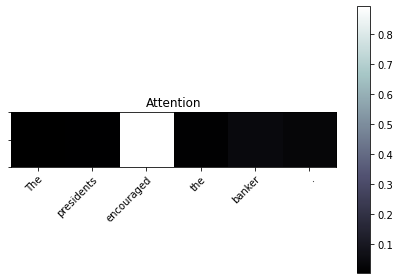

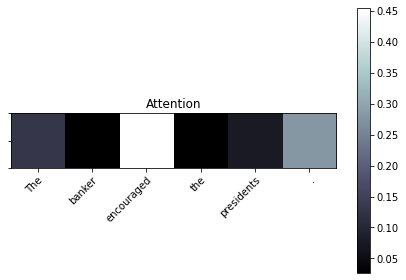

In [45]:
vis.visualize_instance(devset[2])

In [37]:
ed = devset[0].fields["g_p"].edge_indices
nodes = instance2json(devset[0])["sentence1"]

In [38]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

ed = devset[0].fields["g_p"].edge_indices
et = devset[0].fields["g_p"].labels
nodes = instance2json(devset[0])["sentence1"]
G = Data(edge_index=ed, node_attr=nodes, edge_attr=et, num_nodes=len(nodes))

[0, 1, 2, 3, 4, 5]
[(0, 1), (1, 0), (1, 2), (2, 1), (2, 4), (2, 5), (2, 3), (3, 4), (3, 2), (4, 3), (4, 2), (4, 5), (5, 2), (5, 4)]


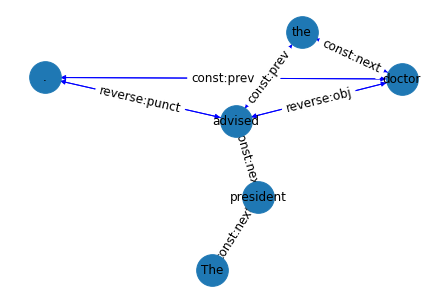

In [39]:
from src.data_git.utils import draw
draw(G)

# Probing Here

In [40]:
# load nlp
from src.data_git.reader import NLIGraphReader
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
rdr_nlp = NLIGraphReader(
        wordpiece_tokenizer = None,
        token_indexers = None,
        combine_input_fields = None,
        input_parsed  = False,
        parser = nlp,
        input_fields = None,
)

2020-09-11 17:45:35 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-09-11 17:45:35 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-09-11 17:45:35 INFO: Use device: gpu
2020-09-11 17:45:35 INFO: Loading: tokenize
2020-09-11 17:45:40 INFO: Loading: pos
2020-09-11 17:45:41 INFO: Loading: lemma
2020-09-11 17:45:41 INFO: Loading: depparse
2020-09-11 17:45:42 INFO: Done loading processors!


In [187]:
probe_json = {
    "sentence1": "from Egipt to America.",
    "sentence2" : "from America to  Egipt.",
    "gold_label": "contradiction",
}

probe_json = {
    "sentence1": "A old man is standing besides a river bank.",
    "sentence2" : "A old man is not standing besides a river bank.",
    "gold_label": "contradiction",
}

probe_json = {
    "sentence1": "Allen travels from America to China",
    "sentence2" : "Allen travels from China to America",
    "gold_label": "contradiction",
}
probe_json = {
    "sentence1": "Alice is flying. Chris is eating. Bob is fishing.",
    "sentence2" : "Alice is not flying. Chris is eating. Bob is fishing.",
    "gold_label": "contradiction",
}
# long negation
probe_json = {
    "sentence1": "Alice does not like to eat pizza. Chris likes to eat pizza. Bob likes to eat pizza.",
    "sentence2" : "Alice likes to eat pizza. Chris likes to eat pizza. Bob likes to eat pizza.",
    "gold_label": "contradiction",
}
# lexical swap
probe_json = {
    "sentence1": "Allen travels from America to China",
    "sentence2" : "Allen travels from China to America",
    "gold_label": "contradiction",
}

2020-09-15 11:20:54 INFO: tokens_p are ['Alice', 'does', 'not', 'like', 'to', 'eat', 'pizza', '.', 'Chris', 'likes', 'to', 'eat', 'pizza', '.', 'Bob', 'likes', 'to', 'eat', 'pizza', '.']
2020-09-15 11:20:54 INFO: tokens_h are ['Alice', 'likes', 'to', 'eat', 'pizza', '.', 'Chris', 'likes', 'to', 'eat', 'pizza', '.', 'Bob', 'likes', 'to', 'eat', 'pizza', '.']
2020-09-15 11:20:54 INFO: the predicted label is ['entailment']
2020-09-15 11:20:54 INFO: the gold label is contradiction


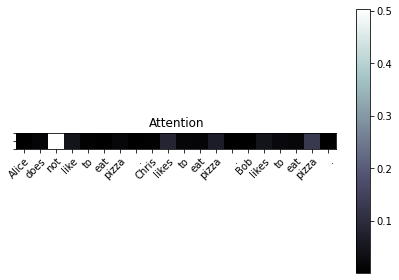

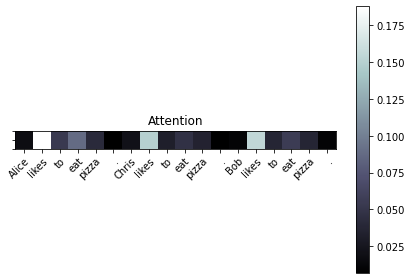

2020-09-15 11:20:55 INFO: matrix attention at layer 0


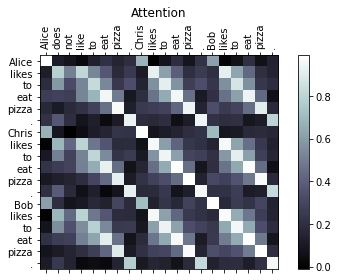

2020-09-15 11:20:55 INFO: matrix attention at layer 1


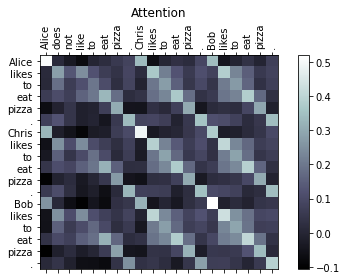

2020-09-15 11:20:55 INFO: matrix attention at layer 2


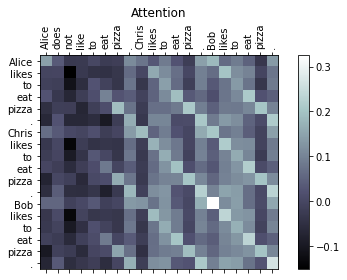

In [188]:
vis_probe.visualize_json(probe_json)

In [92]:
%pwd

'/work/2020-IIS-NLU-internship/MNLI/tests'

In [154]:
probe_json = {
    "sentence1": "A old man is standing besides a river bank.",
    "sentence2" : "A old man is not standing besides a river bank.",
    "gold_label": "contradiction",
}

In [184]:
folder_name = "lexical_swap"
sdir = f"/work/2020-IIS-NLU-internship/MNLI/tests/attention_images/{folder_name}/"

In [185]:
sdir

'/work/2020-IIS-NLU-internship/MNLI/tests/attention_images/lexical_swap/'

2020-09-15 10:01:46 INFO: tokens_p are ['Allen', 'travels', 'from', 'America', 'to', 'China']
2020-09-15 10:01:46 INFO: tokens_h are ['Allen', 'travels', 'from', 'China', 'to', 'America']
2020-09-15 10:01:46 INFO: the predicted label is ['contradiction']
2020-09-15 10:01:46 INFO: the gold label is contradiction


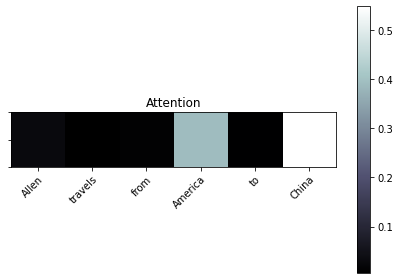

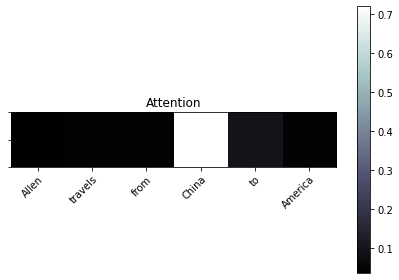

2020-09-15 10:01:46 INFO: matrix attention at layer 0


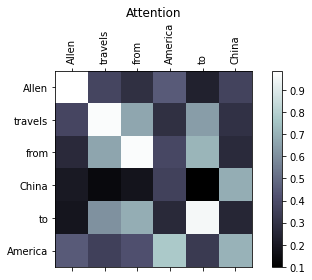

2020-09-15 10:01:47 INFO: matrix attention at layer 1


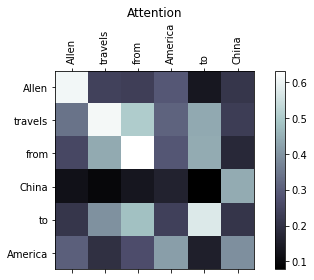

2020-09-15 10:01:47 INFO: matrix attention at layer 2


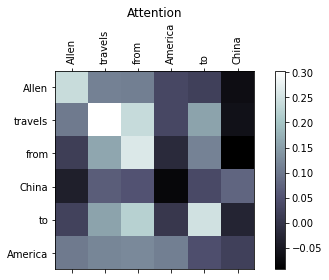

In [186]:
vis_probe.visualize_json(probe_json, serialization_dir=sdir)